# IT1244 Project

## Import Libraries

In [22]:
import re as re
import heapq as heapq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import random as random
from sklearn.preprocessing import StandardScaler
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.decomposition import PCA
import torch as torch
from transformers import AutoModel
from transformers import AutoTokenizer, BertTokenizerFast
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:
def accuracy_score(y_test, y_pred):
    return sum(y_test == y_pred)/len(y_test)

In [3]:
def metrics(y_true, y_guess, table = False, model_name = "", digits=4):
    CM = confusion_matrix(y_true, y_guess)
    TN, FN, TP, FP =  CM[0][0], CM[1][0], CM[1][1], CM[0][1]
    accuracy = np.round((TP+TN)/(TP+TN+FP+FN), digits)
    precision = np.round(TP/(TP+FP), digits)
    recall =  np.round(TP/(TP+FN), digits)
    f1_score =  np.round(2*(precision*recall)/(precision+recall), digits)
    if not table:
        return accuracy, precision, recall, f1_score
    else:
        if not model_name:
            return pd.DataFrame({'accuracy': [accuracy], 'precision': [precision], 'recall': [recall], 'f1_score': [f1_score]})
        else:
            return pd.DataFrame({'model':[model_name], 'accuracy': [accuracy], 'precision': [precision], 'recall': [recall], 'f1_score': [f1_score]})

## Data Importing

In [11]:
tweets = pd.read_csv("../Data/Raw/dataset.csv", header=None)
tweets.head()

,0,1
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Bert Encoding

In [17]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=True)
model = AutoModel.from_pretrained('vinai/bertweet-base')

In [6]:
def bert_encode(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        output = model(**inputs)
    return output.last_hidden_state[:, 0, :]


In [ ]:
sentence_vectors = tweets[1].apply(lambda x: bert_encode(x))
data = np.array(list(map(lambda x: x[0], sentence_vectors)))
data_frame = pd.DataFrame(data)
data_frame.to_csv("../Data/Cleaned/BERT_Vectors.csv")

### Read the CSV data file

In [12]:
Bert_Encoded_Text = pd.read_csv("../Data/Cleaned/BERT_Vectors.csv").iloc[: , 1:]
X = Bert_Encoded_Text
y = tweets[0]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Example: Create a random numpy array to simulate BERT embeddings
bert_vectors = Bert_Encoded_Text  # Example: 100 samples, 768-dimensional BERT vectors

# Step 1: Standardize the data (zero mean, unit variance)
scaler = StandardScaler()
bert_vectors_scaled = scaler.fit_transform(bert_vectors)

# Step 2: Apply PCA to reduce dimensions
n_components = 100  # Desired number of principal components, you can adjust it
pca = PCA(n_components=n_components)
bert_vectors_pca = pca.fit_transform(bert_vectors_scaled)

# Step 3: Output the reduced dimensionality vectors
print(f"Original shape: {bert_vectors.shape}")
print(f"Reduced shape: {bert_vectors_pca.shape}")


Original shape: (100000, 768)
Reduced shape: (100000, 100)


In [45]:
bert_vectors_scaled = scaler.fit_transform(Bert_Encoded_Text)

In [33]:
X = bert_vectors_pca
y = tweets[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
k_values = [i for i in range(1, 50, 2)]
scores = []

for k in k_values:
    print(f"doing {k} now")
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=5)
    scores.append(np.mean(score))

results = list(map(lambda x: float(x), scores))

doing 1 now
doing 3 now
doing 5 now
doing 7 now
doing 9 now
doing 11 now
doing 13 now
doing 15 now
doing 17 now
doing 19 now
doing 21 now
doing 23 now
doing 25 now
doing 27 now
doing 29 now
doing 31 now
doing 33 now
doing 35 now
doing 37 now
doing 39 now
doing 41 now
doing 43 now
doing 45 now
doing 47 now
doing 49 now


### Find Optimal Dimension for PCA

In [ ]:
model_results = []

for dim in range(25, 768, 25):
    print(f"currently in dimension {dim}")
    n_components = dim  # Desired number of principal components, you can adjust it
    pca = PCA(n_components=n_components)
    bert_vectors_pca = pca.fit_transform(bert_vectors_scaled)

    X = bert_vectors_pca
    y = tweets[0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    k_values = [i for i in range(1, 50, 2)]
    scores = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        score = cross_val_score(knn, X_train, y_train, cv=5)
        scores.append(np.mean(score))

    results = list(map(lambda x: float(x), scores))

    # Compute the differences between consecutive scores
    score_differences = np.diff(results)

    # Find the index where the difference between scores starts to decrease significantly
    # Look for the point where the difference drops below a threshold
    threshold = 0.001  # You can adjust this threshold based on your observations
    elbow_point = np.where(score_differences < threshold)[0][0]  # Index of the "elbow"

    # The optimal k is the k corresponding to this elbow point
    optimal_k_elbow = k_values[elbow_point]

    #optimal k
    knn_pca = KNeighborsClassifier(n_neighbors=optimal_k_elbow)
    knn_pca.fit(X_train, y_train)
    y_pred_pca = (knn_pca.predict(X_test) > 0.5)
    mi = metrics(y_test, y_pred_pca, table = True, model_name=dim)
    model_results.append(mi)

final_results = pd.concat(model_results).reset_index(drop=True)

currently in dimension 25
currently in dimension 50
currently in dimension 75
currently in dimension 100
currently in dimension 125
currently in dimension 150
currently in dimension 175
currently in dimension 200
currently in dimension 225
currently in dimension 250
currently in dimension 275


Text(0, 0.5, 'Cross-Validation Score')

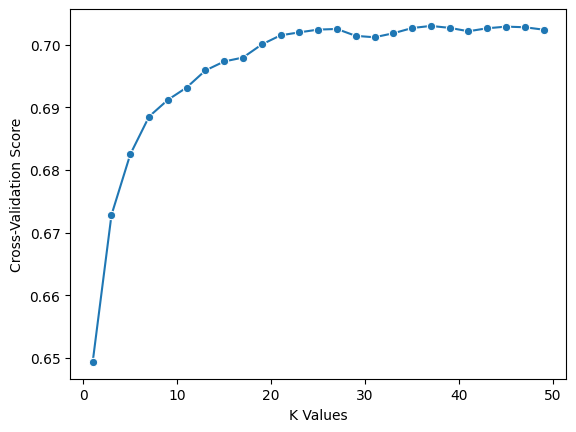

In [35]:
sns.lineplot(x = k_values, y = results, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Cross-Validation Score")

In [38]:
# Compute the differences between consecutive scores
score_differences = np.diff(results)

# Find the index where the difference between scores starts to decrease significantly
# Look for the point where the difference drops below a threshold
threshold = 0.001  # You can adjust this threshold based on your observations
elbow_point = np.where(score_differences < threshold)[0][0]  # Index of the "elbow"

# The optimal k is the k corresponding to this elbow point
optimal_k_elbow = k_values[elbow_point]
print(f"The elbow point suggests the optimal k value is {optimal_k_elbow}")


The elbow point suggests the optimal k value is 15


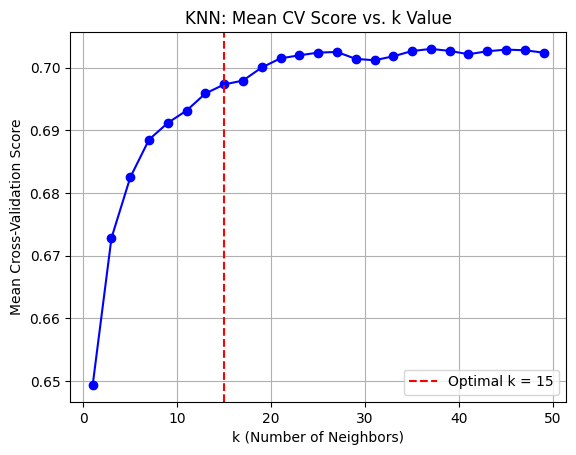

In [39]:
# Plotting k values against their corresponding mean cross-validation scores
plt.plot(k_values, results, marker='o', linestyle='-', color='b')
plt.axvline(x=optimal_k_elbow, color='r', linestyle='--', label=f'Optimal k = {optimal_k_elbow}')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Cross-Validation Score')
plt.title('KNN: Mean CV Score vs. k Value')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
#optimal k is k = 21
knn_pca = KNeighborsClassifier(n_neighbors=15)
knn_pca.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [ ]:
y_pred_pca = knn_pca.predict(X_test) > 0.5

In [31]:
metrics(y_test, y_pred_pca, table = True, model_name="K-NN")

,model,accuracy,precision,recall,f1_score
0,K-NN,0.693,0.6787,0.7288,0.7029


In [43]:
metrics(y_test, y_pred_pca, table = True, model_name="K-NN")

,model,accuracy,precision,recall,f1_score
0,K-NN,0.7032,0.6881,0.7395,0.7129


### K-NN Model

#### N-fold Cross validation

In [ ]:
k_values = [i for i in range(1, 50, 2)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=5)
    scores.append(np.mean(score))

In [ ]:
results = list(map(lambda x: float(x), scores))

Text(0, 0.5, 'Cross-Validation Score')

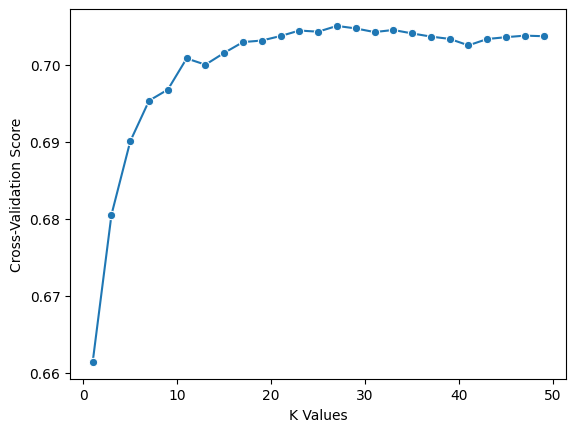

In [ ]:
sns.lineplot(x = k_values, y = results, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Cross-Validation Score")

In [ ]:
#optimal k is k = 5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
cross_val_score(knn, X_train, y_train, cv=5)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:239: 

array([0.695875 , 0.6938125, 0.692375 , 0.6945   , 0.6905625])

In [ ]:
yhat_pred = knn.predict(X_test) > 0.5
y_pred2 = yhat_pred

In [ ]:
metrics(y_test, yhat_pred, table = True, model_name="K-NN")

,model,accuracy,precision,recall,f1_score
0,K-NN,0.69045,0.685813,0.698685,0.692189


## Deep Learning Neural Network

In [123]:
def convert(y_predict):
    return np.array(list(map(lambda x: x[0], y_predict)))

In [145]:
def accuracy_val(model):
    y_hat = convert(model.predict(X_test)) > 0.5
    return float(sum((y_hat == y_test)/len(y_test)))*100

In [103]:
def accuracy_train(model):
    y_hat = model.predict(X_train)
    return float((sum(convert(y_hat >= 0.5) == y_train)/len(y_train))[0])*100

In [7]:
X.shape

(100000, 768)

In [18]:
y = np.array(y)
y = y.reshape(-1, 1)
y.shape

(100000, 1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model.add(Dense(512, input_dim=768, activation='gelu'))
model.add(Dense(512, activation='gelu'))
model.add(Dense(512, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.7584 - loss: 0.4918 - val_accuracy: 0.8108 - val_loss: 0.4182
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8350 - loss: 0.3724 - val_accuracy: 0.8112 - val_loss: 0.4170
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.8574 - loss: 0.3260 - val_accuracy: 0.8086 - val_loss: 0.4294
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8828 - loss: 0.2752 - val_accuracy: 0.8022 - val_loss: 0.4715
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9123 - loss: 0.2072 - val_accuracy: 0.8007 - val_loss: 0.6187
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9382 - loss: 0.1499 - val_accuracy: 0.7983 - val_loss: 0.6893
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9593 - loss: 0.1060 - val_accuracy: 0.7835 - val_loss: 0.7676
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9676 -

In [25]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model.add(Dense(512, input_dim=768, activation='relu'))
model.add(Dropout(0.3))  # Dropout to prevent overfitting
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.7156 - loss: 0.5532 - val_accuracy: 0.8027 - val_loss: 0.4293
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8082 - loss: 0.4221 - val_accuracy: 0.8136 - val_loss: 0.4115
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8241 - loss: 0.3967 - val_accuracy: 0.8135 - val_loss: 0.4119
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8317 - loss: 0.3789 - val_accuracy: 0.8169 - val_loss: 0.4048
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8348 - loss: 0.3695 - val_accuracy: 0.8174 - val_loss: 0.4070
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8394 - loss: 0.3584 - val_accuracy: 0.8181 - val_loss: 0.4024
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8434 - loss: 0.3497 - val_accuracy: 0.8158 - val_loss: 0.4063
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8459 -

In [26]:
accuracy_val(model)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


82.27

In [27]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model0 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model0.add(Dense(512, input_dim=768, activation='gelu'))
model0.add(Dropout(0.3))  # Dropout to prevent overfitting
model0.add(Dense(256, activation='gelu'))
model0.add(Dropout(0.3))
model0.add(Dense(128, activation='gelu'))
model0.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model0.add(Dense(1, activation='sigmoid'))

# Compile the model
model0.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model0.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7261 - loss: 0.5392 - val_accuracy: 0.8019 - val_loss: 0.4291
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8104 - loss: 0.4187 - val_accuracy: 0.8148 - val_loss: 0.4121
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8291 - loss: 0.3865 - val_accuracy: 0.8110 - val_loss: 0.4136
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8349 - loss: 0.3721 - val_accuracy: 0.8148 - val_loss: 0.4052
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8440 - loss: 0.3561 - val_accuracy: 0.8180 - val_loss: 0.4047
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8463 - loss: 0.3470 - val_accuracy: 0.8174 - val_loss: 0.4054
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8511 - loss: 0.3359 - val_accuracy: 0.8194 - val_loss: 0.4049
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8568 -

In [28]:
accuracy_val(model0)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


82.08

In [29]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model1 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model1.add(Dense(512, input_dim=768, activation='relu'))
model1.add(Dropout(0.3))  # Dropout to prevent overfitting
model1.add(Dense(256, activation='gelu'))
model1.add(Dropout(0.3))
model1.add(Dense(128, activation='mish'))
model1.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model1.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7211 - loss: 0.5489 - val_accuracy: 0.8071 - val_loss: 0.4257
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8071 - loss: 0.4218 - val_accuracy: 0.8136 - val_loss: 0.4165
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8199 - loss: 0.3971 - val_accuracy: 0.8146 - val_loss: 0.4105
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8306 - loss: 0.3791 - val_accuracy: 0.8152 - val_loss: 0.4082
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8388 - loss: 0.3637 - val_accuracy: 0.8151 - val_loss: 0.4063
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8430 - loss: 0.3572 - val_accuracy: 0.8191 - val_loss: 0.4052
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8478 - loss: 0.3453 - val_accuracy: 0.8176 - val_loss: 0.4099
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8527 -

In [30]:
accuracy_val(model1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


81.78

In [31]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model2 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model2.add(Dense(512, input_dim=768, activation='gelu'))
model2.add(Dropout(0.3))  # Dropout to prevent overfitting
model2.add(Dense(256, activation='gelu'))
model2.add(Dropout(0.3))
model2.add(Dense(128, activation='gelu'))
model2.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer=AdamW(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.7284 - loss: 0.5353 - val_accuracy: 0.8081 - val_loss: 0.4267
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8138 - loss: 0.4152 - val_accuracy: 0.8160 - val_loss: 0.4178
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8230 - loss: 0.3966 - val_accuracy: 0.8123 - val_loss: 0.4118
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8324 - loss: 0.3778 - val_accuracy: 0.8143 - val_loss: 0.4063
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8345 - loss: 0.3702 - val_accuracy: 0.8161 - val_loss: 0.4061
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.8413 - loss: 0.3606 - val_accuracy: 0.8167 - val_loss: 0.4059
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8465 - loss: 0.3499 - val_accuracy: 0.8207 - val_loss: 0.4050
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.8458 -

In [32]:
accuracy_val(model2)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


82.135

In [33]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model3 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model3.add(Dense(512, input_dim=768, activation='gelu'))
model3.add(Dense(512, input_dim=768, activation='mish'))
model3.add(Dropout(0.3))  # Dropout to prevent overfitting
model3.add(Dense(256, activation='gelu'))
model3.add(Dense(256, activation='tanh'))
model3.add(Dropout(0.3))
model3.add(Dense(128, activation='gelu'))
model3.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(optimizer=AdamW(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8577 - loss: 0.3177 - val_accuracy: 0.8154 - val_loss: 0.4156
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.8603 - loss: 0.3119 - val_accuracy: 0.8166 - val_loss: 0.4267
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.8604 - loss: 0.3093 - val_accuracy: 0.8159 - val_loss: 0.4274
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8640 - loss: 0.3001 - val_accuracy: 0.8177 - val_loss: 0.4208
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.8714 - loss: 0.2889 - val_accuracy: 0.8154 - val_loss: 0.4222
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8732 - loss: 0.2856 - val_accuracy: 0.8112 - val_loss: 0.4428
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8736 - loss: 0.2785 - val_accuracy: 0.8113 - val_loss: 0.4568
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.8764 -

In [34]:
accuracy_val(model3)

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


48.85

In [35]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model4 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model4.add(Dense(512, input_dim=768, activation='mish'))
model4.add(Dropout(0.3))  # Dropout to prevent overfitting
model4.add(Dense(256, activation='tanh'))
model4.add(Dropout(0.3))
model4.add(Dense(128, activation='gelu'))
model4.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model4.add(Dense(1, activation='sigmoid'))

# Compile the model
model4.compile(optimizer=AdamW(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model4.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.7372 - loss: 0.5253 - val_accuracy: 0.8044 - val_loss: 0.4259
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.8101 - loss: 0.4161 - val_accuracy: 0.8149 - val_loss: 0.4084
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8225 - loss: 0.3939 - val_accuracy: 0.8148 - val_loss: 0.4131
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8335 - loss: 0.3756 - val_accuracy: 0.8197 - val_loss: 0.4066
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.8357 - loss: 0.3699 - val_accuracy: 0.8167 - val_loss: 0.4076
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8380 - loss: 0.3616 - val_accuracy: 0.8151 - val_loss: 0.4126
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.8433 - loss: 0.3540 - val_accuracy: 0.8166 - val_loss: 0.4078
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.8458 -

In [36]:
accuracy_val(model4)

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


82.1

In [37]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (80,000, 1)

# Model architecture
model5 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model5.add(Dense(64, input_dim=768, activation='mish'))
model5.add(Dropout(0.3))  # Dropout to prevent overfitting

# Output layer: single neuron with sigmoid activation for binary classification
model5.add(Dense(1, activation='sigmoid'))

# Compile the model
model5.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model5.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7160 - loss: 0.5629 - val_accuracy: 0.8029 - val_loss: 0.4313
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8078 - loss: 0.4207 - val_accuracy: 0.8138 - val_loss: 0.4195
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8170 - loss: 0.4032 - val_accuracy: 0.8160 - val_loss: 0.4089
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8248 - loss: 0.3886 - val_accuracy: 0.8209 - val_loss: 0.4049
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8260 - loss: 0.3837 - val_accuracy: 0.8201 - val_loss: 0.4022
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8377 - loss: 0.3717 - val_accuracy: 0.8190 - val_loss: 0.4040
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8388 - loss: 0.3657 - val_accuracy: 0.8216 - val_loss: 0.4031
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8399 - loss: 0.3640 -

In [38]:
accuracy_val(model5)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


82.41000000000001

In [39]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (80,000, 1)

# Model architecture
model6 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model6.add(Dense(64, input_dim=768, activation='gelu'))
model6.add(Dropout(0.3))  # Dropout to prevent overfitting

# Output layer: single neuron with sigmoid activation for binary classification
model6.add(Dense(1, activation='sigmoid'))

# Compile the model
model6.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model6.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7161 - loss: 0.5602 - val_accuracy: 0.8043 - val_loss: 0.4307
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8046 - loss: 0.4259 - val_accuracy: 0.8127 - val_loss: 0.4149
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8197 - loss: 0.4002 - val_accuracy: 0.8175 - val_loss: 0.4037
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8254 - loss: 0.3871 - val_accuracy: 0.8149 - val_loss: 0.4097
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8321 - loss: 0.3758 - val_accuracy: 0.8209 - val_loss: 0.4014
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8341 - loss: 0.3750 - val_accuracy: 0.8211 - val_loss: 0.4005
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8368 - loss: 0.3695 - val_accuracy: 0.8230 - val_loss: 0.3999
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8391 - loss: 0.3634 -

In [40]:
accuracy_val(model6)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


82.235

In [41]:
from tensorflow.keras.regularizers import l1_l2

model7 = Sequential()
model7.add(Dense(16, input_dim=768, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model7.add(Dropout(0.3))  # Dropout to prevent overfitting
model7.add(Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Output layer: single neuron with sigmoid activation for binary classification
model7.add(Dense(1, activation='sigmoid'))

# Compile the model
model7.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model7.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6367 - loss: 3.0061 - val_accuracy: 0.7246 - val_loss: 0.7448
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7036 - loss: 0.7193 - val_accuracy: 0.7463 - val_loss: 0.6620
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7119 - loss: 0.6799 - val_accuracy: 0.7639 - val_loss: 0.6402
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7216 - loss: 0.6711 - val_accuracy: 0.7663 - val_loss: 0.6313
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7255 - loss: 0.6649 - val_accuracy: 0.7681 - val_loss: 0.6304
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7280 - loss: 0.6577 - val_accuracy: 0.7733 - val_loss: 0.6222
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7253 - loss: 0.6589 - val_accuracy: 0.7673 - val_loss: 0.6223
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7285 - loss: 0.6572 -

In [42]:
accuracy_val(model7)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


77.215

In [43]:
model8 = Sequential()
model8.add(Dense(16, input_dim=768, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

model8.add(Dropout(0.3))  # Dropout to prevent overfitting
model8.add(Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

model8.add(Dropout(0.3))  # Dropout to prevent overfitting
model8.add(Dense(8, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Output layer: single neuron with sigmoid activation for binary classification
model8.add(Dense(1, activation='sigmoid'))

# Compile the model
model8.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model8.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5703 - loss: 2.7607 - val_accuracy: 0.4956 - val_loss: 0.7165
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5047 - loss: 0.7056 - val_accuracy: 0.5044 - val_loss: 0.6996
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4973 - loss: 0.6996 - val_accuracy: 0.4956 - val_loss: 0.6997
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4988 - loss: 0.6997 - val_accuracy: 0.5044 - val_loss: 0.6997
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4990 - loss: 0.6998 - val_accuracy: 0.4956 - val_loss: 0.7001
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5026 - loss: 0.7000 - val_accuracy: 0.4956 - val_loss: 0.7001
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5011 - loss: 0.7001 - val_accuracy: 0.4956 - val_loss: 0.7001
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4992 - loss: 0.7001 - 

In [44]:
accuracy_val(model8)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


50.175000000000004

In [45]:
model9 = Sequential()
model9.add(Dense(16, input_dim=768, activation='gelu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model9.add(Dropout(0.3))  # Dropout to prevent overfitting
model9.add(Dense(16, activation='gelu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Output layer: single neuron with sigmoid activation for binary classification
model9.add(Dense(1, activation='sigmoid'))

# Compile the model
model9.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model9.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6104 - loss: 2.6679 - val_accuracy: 0.7143 - val_loss: 0.6927
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6622 - loss: 0.6901 - val_accuracy: 0.7505 - val_loss: 0.6508
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6785 - loss: 0.6748 - val_accuracy: 0.7584 - val_loss: 0.6378
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6814 - loss: 0.6677 - val_accuracy: 0.7584 - val_loss: 0.6291
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6824 - loss: 0.6645 - val_accuracy: 0.7516 - val_loss: 0.6358
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6883 - loss: 0.6606 - val_accuracy: 0.7601 - val_loss: 0.6225
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6890 - loss: 0.6554 - val_accuracy: 0.7619 - val_loss: 0.6248
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6820 - loss: 0.6575 -

In [46]:
accuracy_val(model9)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


76.47500000000001

In [47]:
model10 = Sequential()
model10.add(Dense(16, input_dim=768, activation='gelu'))
model10.add(Dropout(0.3))  # Dropout to prevent overfitting
model10.add(Dense(16, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model10.add(Dense(1, activation='sigmoid'))

# Compile the model
model10.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model10.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model10)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6811 - loss: 0.5843 - val_accuracy: 0.7911 - val_loss: 0.4476
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7937 - loss: 0.4481 - val_accuracy: 0.8087 - val_loss: 0.4217
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8060 - loss: 0.4213 - val_accuracy: 0.8132 - val_loss: 0.4124
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8150 - loss: 0.4116 - val_accuracy: 0.8141 - val_loss: 0.4081
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8207 - loss: 0.4039 - val_accuracy: 0.8175 - val_loss: 0.4069
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8205 - loss: 0.3981 - val_accuracy: 0.8190 - val_loss: 0.4031
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8227 - loss: 0.3975 - val_accuracy: 0.8204 - val_loss: 0.4017
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8215 - loss: 0.3971 -

82.22500000000001

In [48]:
model11 = Sequential()
model11.add(Dense(16, input_dim=768, activation='gelu'))
model11.add(Dropout(0.3))  # Dropout to prevent overfitting
model11.add(Dense(8, activation='gelu'))
model11.add(Dropout(0.3))  # Dropout to prevent overfitting
model11.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model11.add(Dense(1, activation='sigmoid'))

# Compile the model
model11.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model11.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model11)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6271 - loss: 0.6452 - val_accuracy: 0.7846 - val_loss: 0.4739
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7596 - loss: 0.4913 - val_accuracy: 0.8069 - val_loss: 0.4353
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7883 - loss: 0.4565 - val_accuracy: 0.8112 - val_loss: 0.4196
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8081 - loss: 0.4362 - val_accuracy: 0.8158 - val_loss: 0.4130
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8143 - loss: 0.4212 - val_accuracy: 0.8183 - val_loss: 0.4090
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8154 - loss: 0.4173 - val_accuracy: 0.8164 - val_loss: 0.4075
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8218 - loss: 0.4104 - val_accuracy: 0.8211 - val_loss: 0.4058
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8221 - loss: 0.4053 

82.05

In [49]:
model12 = Sequential()
model12.add(Dense(16, input_dim=768, activation='mish'))
model12.add(Dropout(0.3))  # Dropout to prevent overfitting
model12.add(Dense(8, activation='mish'))
model12.add(Dropout(0.3))  # Dropout to prevent overfitting
model12.add(Dense(4, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model12.add(Dense(1, activation='sigmoid'))

# Compile the model
model12.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model12.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model12)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6514 - loss: 0.6353 - val_accuracy: 0.7794 - val_loss: 0.4981
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7746 - loss: 0.5052 - val_accuracy: 0.8016 - val_loss: 0.4561
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7982 - loss: 0.4636 - val_accuracy: 0.8094 - val_loss: 0.4349
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8060 - loss: 0.4433 - val_accuracy: 0.8168 - val_loss: 0.4225
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8154 - loss: 0.4272 - val_accuracy: 0.8156 - val_loss: 0.4210
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8179 - loss: 0.4254 - val_accuracy: 0.8196 - val_loss: 0.4090
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8179 - loss: 0.4188 - val_accuracy: 0.8184 - val_loss: 0.4108
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8227 - loss: 0.4133

82.17

In [50]:
model13 = Sequential()
model13.add(Dense(16, input_dim=768, activation='mish'))
model13.add(Dropout(0.3))  # Dropout to prevent overfitting
model13.add(Dense(8, activation='mish'))
model13.add(Dropout(0.3))  # Dropout to prevent overfitting
model13.add(Dense(4, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model13.add(Dense(1, activation='sigmoid'))

# Compile the model
model13.compile(optimizer=AdamW(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model13.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model13)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5545 - loss: 0.8302 - val_accuracy: 0.6726 - val_loss: 0.6118
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6633 - loss: 0.6255 - val_accuracy: 0.7217 - val_loss: 0.5658
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7090 - loss: 0.5809 - val_accuracy: 0.7551 - val_loss: 0.5281
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7389 - loss: 0.5442 - val_accuracy: 0.7717 - val_loss: 0.4935
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7632 - loss: 0.5117 - val_accuracy: 0.7857 - val_loss: 0.4660
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7786 - loss: 0.4847 - val_accuracy: 0.7949 - val_loss: 0.4487
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7894 - loss: 0.4663 - val_accuracy: 0.8008 - val_loss: 0.4370
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7955 - loss: 0.4577

81.355

In [51]:
model14 = Sequential()
model14.add(Dense(8, input_dim=768, activation='mish'))
model14.add(Dropout(0.3))  # Dropout to prevent overfitting

model14.add(Dense(4, activation='mish'))
model14.add(Dropout(0.3))  # Dropout to prevent overfitting

model14.add(Dense(4, activation='mish'))
model14.add(Dropout(0.3))  # Dropout to prevent overfitting

model14.add(Dense(2, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model14.add(Dense(1, activation='sigmoid'))

# Compile the model
model14.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model14.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model14)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6007 - loss: 0.6756 - val_accuracy: 0.7694 - val_loss: 0.5333
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7383 - loss: 0.5654 - val_accuracy: 0.7948 - val_loss: 0.4688
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7765 - loss: 0.5108 - val_accuracy: 0.8069 - val_loss: 0.4438
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7894 - loss: 0.4792 - val_accuracy: 0.8104 - val_loss: 0.4345
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7951 - loss: 0.4698 - val_accuracy: 0.8154 - val_loss: 0.4231
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8049 - loss: 0.4543 - val_accuracy: 0.8164 - val_loss: 0.4174
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8044 - loss: 0.4500 - val_accuracy: 0.8207 - val_loss: 0.4131
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8093 - loss: 0.4423 

81.955

In [52]:
model15 = Sequential()
model15.add(Dense(4, input_dim=768, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(4, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(4, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(4, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(2, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model15.add(Dense(1, activation='sigmoid'))

# Compile the model
model15.compile(optimizer=AdamW(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model15.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6111 - loss: 0.6586 - val_accuracy: 0.7709 - val_loss: 0.5175
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7214 - loss: 0.5690 - val_accuracy: 0.7922 - val_loss: 0.4662
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7563 - loss: 0.5269 - val_accuracy: 0.8041 - val_loss: 0.4452
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7744 - loss: 0.4978 - val_accuracy: 0.8031 - val_loss: 0.4394
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7813 - loss: 0.4860 - val_accuracy: 0.8129 - val_loss: 0.4290
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7939 - loss: 0.4714 - val_accuracy: 0.8127 - val_loss: 0.4269
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7958 - loss: 0.4678 - val_accuracy: 0.8100 - val_loss: 0.4271
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7948 - loss: 0.4679 

In [53]:
model16 = Sequential()
model16.add(Dense(16, input_dim=768, activation='gelu'))
model16.add(Dropout(0.3))  # Dropout to prevent overfitting
model16.add(Dense(8, activation='gelu'))
model16.add(Dropout(0.3))  # Dropout to prevent overfitting
model16.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model16.add(Dense(1, activation='sigmoid'))

# Compile the model
model16.compile(optimizer=AdamW(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model16.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)
accuracy_val(model16)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5395 - loss: 0.7297 - val_accuracy: 0.6682 - val_loss: 0.6332
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6527 - loss: 0.6315 - val_accuracy: 0.7126 - val_loss: 0.5945
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7018 - loss: 0.5965 - val_accuracy: 0.7386 - val_loss: 0.5617
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7364 - loss: 0.5650 - val_accuracy: 0.7577 - val_loss: 0.5354
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7466 - loss: 0.5453 - val_accuracy: 0.7676 - val_loss: 0.5163
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7595 - loss: 0.5293 - val_accuracy: 0.7757 - val_loss: 0.5019
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7709 - loss: 0.5114 - val_accuracy: 0.7835 - val_loss: 0.4888
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7791 - loss: 0

82.145

In [54]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [55]:
model17 = Sequential()
model17.add(Dense(16, input_dim=768, activation='gelu'))
model17.add(Dropout(0.3))  # Dropout to prevent overfitting
model17.add(Dense(8, activation='gelu'))
model17.add(Dropout(0.3))  # Dropout to prevent overfitting
model17.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model17.add(Dense(1, activation='sigmoid'))

# Compile the model
model17.compile(optimizer=AdamW(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model17.fit(X_train, y_train, epochs=52, batch_size=64, validation_split=0.2)
accuracy_val(model17)

Epoch 1/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5341 - loss: 0.8452 - val_accuracy: 0.6438 - val_loss: 0.6541
Epoch 2/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6363 - loss: 0.6481 - val_accuracy: 0.6948 - val_loss: 0.6144
Epoch 3/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6823 - loss: 0.6118 - val_accuracy: 0.7266 - val_loss: 0.5789
Epoch 4/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7198 - loss: 0.5816 - val_accuracy: 0.7445 - val_loss: 0.5543
Epoch 5/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7375 - loss: 0.5587 - val_accuracy: 0.7593 - val_loss: 0.5331
Epoch 6/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7512 - loss: 0.5409 - val_accuracy: 0.7709 - val_loss: 0.5156
Epoch 7/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7636 - loss: 0.5231 - val_accuracy: 0.7747 - val_loss: 0.5049
Epoch 8/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7699 - loss: 0.5124 -

81.685

In [56]:
model18 = Sequential()
model18.add(Dense(16, input_dim=768, activation='gelu'))
model18.add(Dropout(0.3))  # Dropout to prevent overfitting
model18.add(Dense(8, activation='gelu'))
model18.add(Dropout(0.3))  # Dropout to prevent overfitting
model18.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model18.add(Dense(1, activation='sigmoid'))

# Compile the model
model18.compile(optimizer=AdamW(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model18.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
accuracy_val(model18)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5628 - loss: 0.6933 - val_accuracy: 0.6973 - val_loss: 0.5947
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6734 - loss: 0.6012 - val_accuracy: 0.7471 - val_loss: 0.5281
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7225 - loss: 0.5531 - val_accuracy: 0.7686 - val_loss: 0.4908
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7525 - loss: 0.5197 - val_accuracy: 0.7840 - val_loss: 0.4675
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7714 - loss: 0.4949 - val_accuracy: 0.7909 - val_loss: 0.4518
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7806 - loss: 0.4793 - val_accuracy: 0.7956 - val_loss: 0.4418
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7856 - loss: 0.4698 - val_accuracy: 0.8012 - val_loss: 0.4326
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7921 - lo

82.5

In [57]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
modeli = Sequential()

# Input layer: (768,) is the shape of each BERT vector
modeli.add(Dense(512, input_dim=768, activation='relu'))
modeli.add(Dropout(0.3))  # Dropout to prevent overfitting
modeli.add(Dense(256, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(128, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(64, activation='gelu'))
modeli.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
modeli.add(Dense(1, activation='sigmoid'))

# Compile the model
modeli.compile(optimizer=AdamW(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
modeli.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(modeli)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.6428 - loss: 0.6333 - val_accuracy: 0.7784 - val_loss: 0.4728
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7753 - loss: 0.4803 - val_accuracy: 0.8044 - val_loss: 0.4344
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8029 - loss: 0.4340 - val_accuracy: 0.8109 - val_loss: 0.4172
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8137 - loss: 0.4127 - val_accuracy: 0.8163 - val_loss: 0.4091
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8274 - loss: 0.3894 - val_accuracy: 0.8181 - val_loss: 0.4047
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.8342 - loss: 0.3747 - val_accuracy: 0.8189 - val_loss: 0.4013
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8375 - loss: 0.3667 - val_accuracy: 0.8196 - val_loss: 0.3996
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8431 -

81.935

In [58]:
models = [model, model0, model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, model12, model13, model14, model15, model16, model17, model18, modeli]

In [59]:
model_results = []

for Model in models:
    model_results.append((Model.count_params(), accuracy_val(Model)))

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


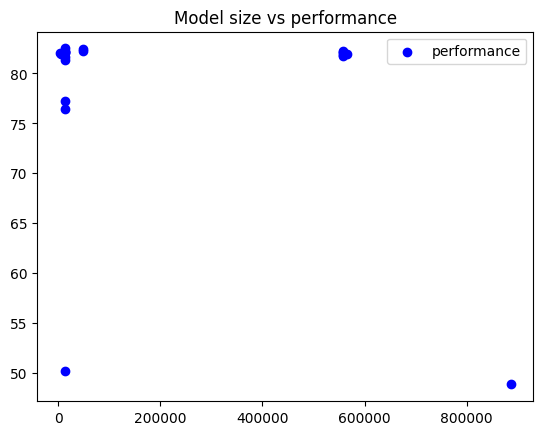

In [60]:
x,y = [], []

for Model in model_results:
    x.append(Model[0])
    y.append(Model[1])

plt.scatter(x, y, label = 'performance', color="blue")

plt.title("Model size vs performance")
plt.legend()

plt.show()


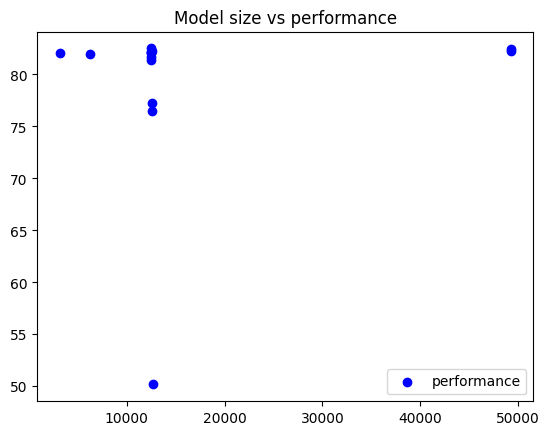

In [61]:
x,y = [], []

for Model in model_results:
    if (Model[0] < 100000):
        x.append(Model[0])
        y.append(Model[1])

plt.scatter(x, y, label = 'performance', color="blue")

plt.title("Model size vs performance")
plt.legend()

plt.show()


In [62]:
model_results

[(558081, 82.27),
 (558081, 82.08),
 (558081, 81.78),
 (558081, 81.88499999999999),
 (886529, 48.85),
 (558081, 82.1),
 (49281, 82.41000000000001),
 (49281, 82.235),
 (12593, 77.215),
 (12721, 50.175000000000004),
 (12593, 76.47500000000001),
 (12593, 82.22500000000001),
 (12481, 82.05),
 (12481, 82.17),
 (12481, 81.355),
 (6221, 81.955),
 (3149, 82.04),
 (12481, 82.145),
 (12481, 81.685),
 (12481, 82.5),
 (566273, 81.935)]

In [63]:
model_family = []

In [64]:
model_family.append(modeli)

In [65]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
modeli = Sequential()

# Input layer: (768,) is the shape of each BERT vector
modeli.add(Dense(256, input_dim=768, activation='relu'))
modeli.add(Dropout(0.3))  # Dropout to prevent overfitting
modeli.add(Dense(256, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(128, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(64, activation='gelu'))
modeli.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
modeli.add(Dense(1, activation='sigmoid'))

# Compile the model
modeli.compile(optimizer=AdamW(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
modeli.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(modeli)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.6156 - loss: 0.6569 - val_accuracy: 0.7703 - val_loss: 0.4894
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.7643 - loss: 0.4938 - val_accuracy: 0.7933 - val_loss: 0.4449
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7902 - loss: 0.4528 - val_accuracy: 0.8025 - val_loss: 0.4254
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.8069 - loss: 0.4272 - val_accuracy: 0.8087 - val_loss: 0.4155
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8133 - loss: 0.4103 - val_accuracy: 0.8151 - val_loss: 0.4081
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8235 - loss: 0.3907 - val_accuracy: 0.8174 - val_loss: 0.4039
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.8288 - loss: 0.3849 - val_accuracy: 0.8188 - val_loss: 0.4027
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8372 -

82.38

### Results

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


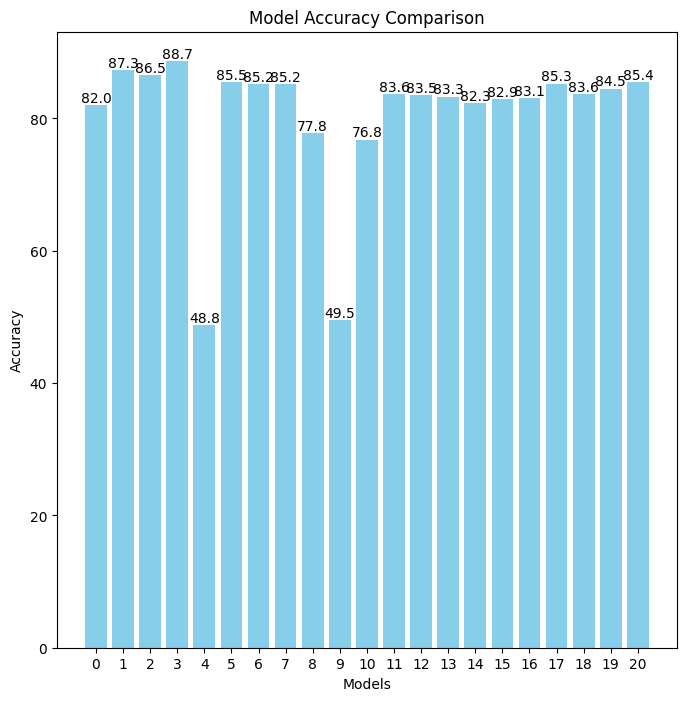

In [202]:
# Given list of models
models = [model, model0, model1, model2, model3, 
          model4, model5, model6, model7, model8, 
          model9, model10, model11, model12, model13, 
          model14, model15, model16, model17, model18, 
          modeli]

# Compute accuracy values
accuracies = [accuracy_val(m) for m in models]

# Generate model names as labels
model_names = [f"{i}" for i in range(len(models))]

models_perf = pd.DataFrame({'model': models, 'accuracy': accuracies})


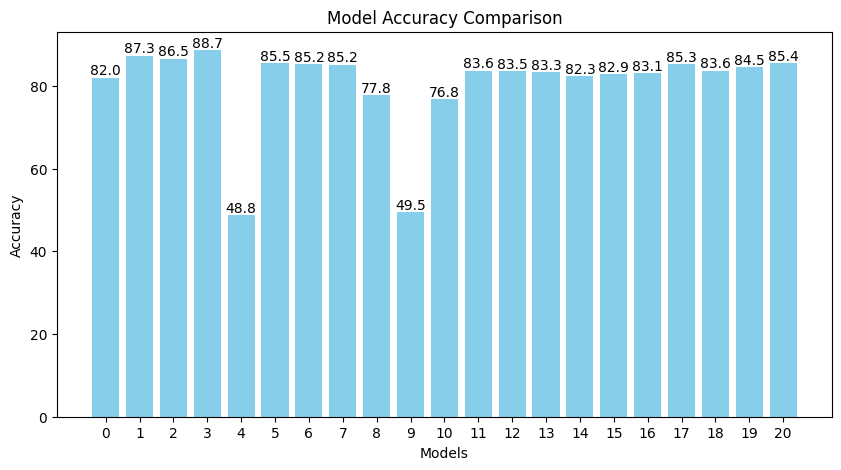

In [203]:

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color='skyblue')

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

# Show values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.1f}", ha='center', va='bottom')

# Display the plot
plt.show()


In [ ]:
accuracies

[82.27,
 82.08,
 81.78,
 81.88499999999999,
 48.85,
 82.1,
 82.41000000000001,
 82.235,
 77.215,
 50.175000000000004,
 76.47500000000001,
 82.22500000000001,
 82.05,
 82.17,
 81.355,
 81.955,
 82.04,
 82.145,
 81.685,
 82.5,
 82.38]

In [67]:
float(np.mean(accuracies))

78.4752380952381

In [68]:
float(np.median(accuracies))

82.05

In [150]:
float(np.std(accuracies))

9.52606118025584

In [69]:
(float(np.min(accuracies)), float(np.max(accuracies)))

(48.85, 82.5)

### Drop Models 4,8,9,10,15

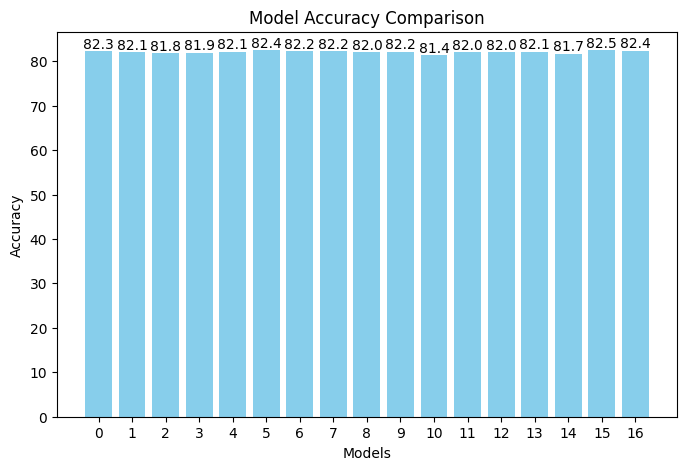

In [70]:
# Drop rows where accuracy is less than 0.80
good_models_perf = models_perf[models_perf['accuracy'] >= 80]

# Generate model names as labels
model_names = [f"{i}" for i in range(len(good_models_perf))]

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(model_names, good_models_perf.accuracy, color='skyblue')

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

# Show values on bars
for i, acc in enumerate(good_models_perf.accuracy):
    plt.text(i, acc, f"{acc:.1f}", ha='center', va='bottom')

# Display the plot
plt.show()


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


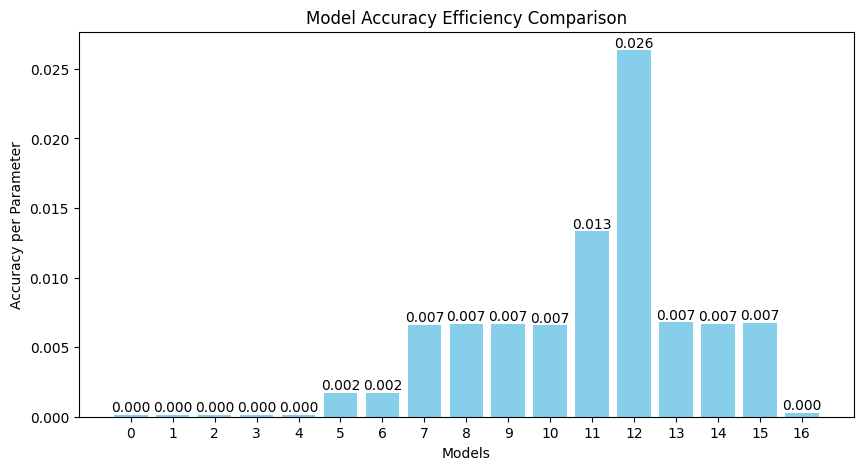

In [147]:
# Given list of models
remaining_models = good_models_perf.model

# Compute accuracy per parameter values
accuracy_efficiencies = [accuracy_val(m)/(m.count_params()) for m in remaining_models]

# Generate model names as labels
model_names = [f"{i}" for i in range(len(remaining_models))]

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracy_efficiencies, color='skyblue')

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy per Parameter")
plt.title("Model Accuracy Efficiency Comparison")

# Show values on bars
for i in range(len(accuracy_efficiencies)):
    acc = accuracy_efficiencies[i]
    plt.text(i, acc, f"{acc:.3f}", ha='center', va='bottom')

# Display the plot
plt.show()


In [149]:
accuracy_stats = [(accuracy_val(m),m.count_params()) for m in remaining_models]

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [164]:
efficiency = pd.DataFrame([(acc/paras, acc,paras) for acc,paras in accuracy_stats])

In [161]:
max(pd.DataFrame(efficiency)[0])

0.026348046999044677

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


array([ True,  True,  True, ..., False, False, False])

In [171]:
metrics(y_test, (convert(model15.predict(X_test)) > 0.5), table = True, model_name="Best NN")

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


,model,accuracy,precision,recall,f1_score
0,Best NN,0.8297,0.8298,0.8316,0.8307


In [165]:
efficiency

,0,1,2
0,0.000154,85.950,558081
1,0.000156,87.195,558081
2,0.000154,86.190,558081
3,0.000158,88.435,558081
4,0.000152,84.895,558081
5,0.001720,84.755,49281
6,0.001724,84.960,49281
7,0.006625,83.430,12593
8,0.006691,83.505,12481
9,0.006673,83.280,12481


In [79]:
def convert(y_predict):
    return np.array(list(map(lambda x: x[0], y_predict)))

In [81]:
model15.predict(X_test) > 0.5

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


array([[False],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [False]])

In [122]:
float(metrics(y_test, convert(model15.predict(X_test) > 0.5), table = True, model_name="Neural Network")["accuracy"][0])

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


0.8297

### Best Performing and Efficient Deep Neural Network

In [ ]:
best_model = remaining_models[accuracy_efficiencies.index(max(accuracy_efficiencies))]

In [110]:
sum(convert(best_model.predict(X_train)>0.5) == y_train)/len(y_train)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


0.834075

In [112]:
metrics(y_test, convert(best_model.predict(X_test)>0.5), table = True, model_name="Best NN")

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


,model,accuracy,precision,recall,f1_score
0,Best NN,0.835,0.8375,0.8334,0.8354


In [114]:
best_model.count_params()

12481

In [113]:
metrics(y_test, convert(model15.predict(X_test)>0.5), table = True, model_name="Model 15")

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


,model,accuracy,precision,recall,f1_score
0,Model 15,0.8297,0.8298,0.8316,0.8307


In [72]:
best_stats = (best_model.count_params(), accuracy_train(best_model), accuracy_val(best_model))
print(f"Model has {best_stats[0]} parameters")
print(f"Model has train accuracy of {best_stats[1]}%,")
print(f"Model has test accuracy of {best_stats[2]}%,")

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Model has 3149 parameters
Model has train accuracy of 82.83875%,
Model has test accuracy of 82.04%,


In [73]:
from sklearn.metrics import confusion_matrix

In [74]:
y_pred3 = model15.predict(X_test) > 0.5
CM = confusion_matrix(y_test, y_pred3)
CM

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


array([[8249, 1786],
       [1806, 8159]])

In [75]:
metrics(y_test, y_pred3, table = True, model_name="Neural Network")

,model,accuracy,precision,recall,f1_score
0,Neural Network,0.8204,0.8204,0.8188,0.8196


## K-Means++ & Deep Learning Neural Network

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, tweets[0], test_size=0.2)

In [175]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [176]:
def sklearnKmeans_plus(X, k, m):
    '''
    X: numpy array, shape = [N, D]
    k: int value
    m: int value
    RETURN
        position: numpy array, shape = [N]
        centers: numpy array, shape = [k, D]
    '''
    position, centers = None, None
    ## start your code here
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=1, max_iter=m).fit(X)
    position, centers = kmeans.predict(X), kmeans.cluster_centers_
    
    # Compute WSS
    WSS = np.sum((X - centers[position])**2)
    
    return position, centers, WSS

In [177]:
cluster_assignments = {}  # Dictionary to store assigned data points

wss_values = []  # Store WSS for each k
k_values = list(range(1, 11))  # k from 1 to 30

for k in k_values:
    print(f"at {k} k-value now")
    position, centers, WSS = sklearnKmeans_plus(X_train, k, 1000)
    
    # Store the WSS value for plotting
    wss_values.append(WSS)

    # Store cluster assignments (optional for later)
    cluster_assignments[k] = {
        "positions": position,
        "centers": centers,
        "WSS": WSS
    }


at 1 k-value now
at 2 k-value now
at 3 k-value now
at 4 k-value now
at 5 k-value now
at 6 k-value now
at 7 k-value now
at 8 k-value now
at 9 k-value now
at 10 k-value now


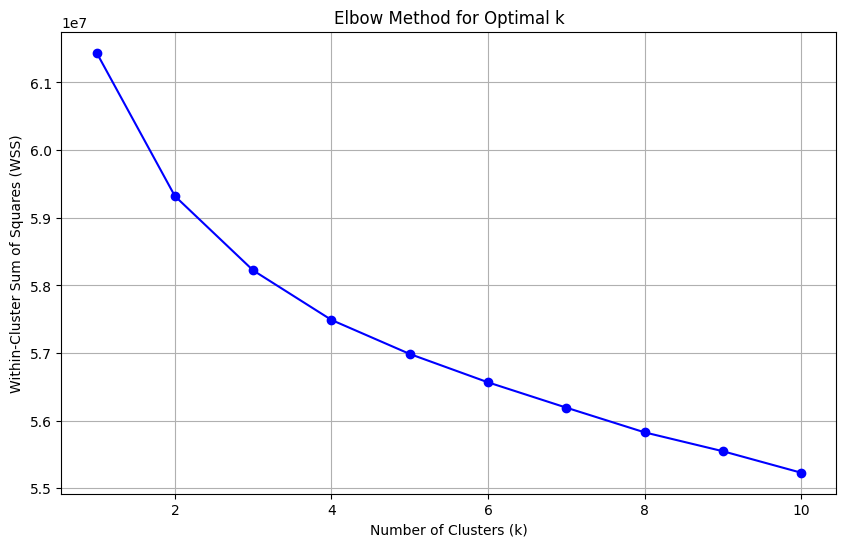

In [178]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, wss_values, marker='o', linestyle='-', color='b')

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)

plt.show()

Optimal k found at: 4


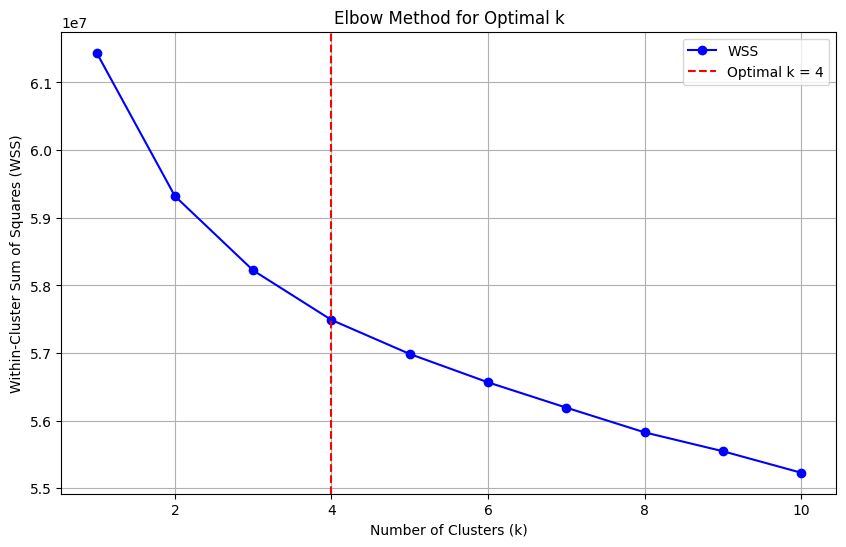

In [179]:
from kneed import KneeLocator

knee_locator = KneeLocator(k_values, wss_values, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow

print(f"Optimal k found at: {optimal_k}")

# Plot again with optimal k highlighted
plt.figure(figsize=(10, 6))
plt.plot(k_values, wss_values, marker='o', linestyle='-', color='b', label="WSS")
plt.axvline(optimal_k, color='r', linestyle='--', label=f"Optimal k = {optimal_k}")

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.title("Elbow Method for Optimal k")
plt.legend()
plt.grid(True)

plt.show()


In [180]:

def train_dnn(X, Y, position, cluster):
    # Create a mask where the position matches the index
    mask = (position == cluster)

    # Apply mask to keep only the relevant Y values
    y_train = Y[mask]
    X_train = X[mask]
    
    # Remove zero entries
    X_train = X_train[~np.all(X_train == 0, axis=1)]
    y_train = y_train[~np.all(X_train == 0, axis=1)]  # Ensure y_train is aligned



    new_model = Sequential()
    new_model.add(Dense(4, input_dim=768, activation='mish'))
    new_model.add(Dropout(0.3))  # Dropout to prevent overfitting

    new_model.add(Dense(2, activation='mish'))
    new_model.add(Dropout(0.3))  # Dropout to prevent overfitting

    # Output layer: single neuron with sigmoid activation for binary classification
    new_model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    new_model.compile(optimizer=AdamW(learning_rate=0.0005), 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                   patience=100,  # Number of epochs to wait before stopping if no improvement
                                   restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                   verbose=1)

    # Train the model
    new_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

    return new_model

In [181]:
optimal_cluster = cluster_assignments[optimal_k]['positions']
optimal_cluster

array([1, 1, 3, ..., 0, 0, 0], dtype=int32)

In [182]:
count = [i for i in range(4)]
for i in range(4):
    count[i] = int(sum(optimal_cluster == i))
count

[18824, 22712, 14262, 24202]

In [183]:
cluster_models = {}  # Dictionary to store cluster-wise DNN models

# Train a separate Deep Neural Network for each cluster
for cluster in range(4):
    cluster_models[cluster] = train_dnn(X_train, y_train, optimal_cluster, cluster)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5809 - loss: 0.7010 - val_accuracy: 0.6645 - val_loss: 0.6461
Epoch 2/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6472 - loss: 0.6513 - val_accuracy: 0.7102 - val_loss: 0.6124
Epoch 3/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6742 - loss: 0.6267 - val_accuracy: 0.7394 - val_loss: 0.5786
Epoch 4/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7092 - loss: 0.5972 - val_accuracy: 0.7445 - val_loss: 0.5622
Epoch 5/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7078 - loss: 0.5860 - val_accuracy: 0.7625 - val_loss: 0.5425
Epoch 6/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7284 - loss: 0.5661 - val_accuracy: 0.7607 - val_loss: 0.5315
Epoch 7/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7216 - loss: 0.5598 - val_accuracy: 0.7695 - val_loss: 0.5208
Epoch 8/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7275 - loss: 0.5569 - val_accu

### Inner Cluster Model Evaluation

In [184]:
cluster_models

{0: <Sequential name=sequential_25, built=True>,
 1: <Sequential name=sequential_26, built=True>,
 2: <Sequential name=sequential_27, built=True>,
 3: <Sequential name=sequential_28, built=True>}

In [185]:
cluster_models[2].count_params()

3089

In [186]:
k_values = [i for i in range(1, 12, 2)]
scores = []

for k in k_values:
    print(f"at {k} k-value now")
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, optimal_cluster, cv=5)
    scores.append(np.mean(score))

at 1 k-value now
at 3 k-value now
at 5 k-value now
at 7 k-value now
at 9 k-value now
at 11 k-value now


Text(0, 0.5, 'Cross-Validation Score')

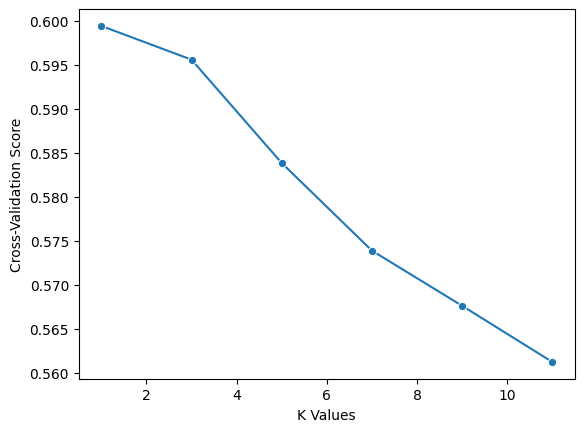

In [187]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Cross-Validation Score")

In [188]:
optimal_kneighbour = k_values[scores.index(max(scores))]

In [189]:
knn = KNeighborsClassifier(n_neighbors=optimal_kneighbour)
knn.fit(X_train, optimal_cluster)
cluser_hat = knn.predict(X_test)

In [191]:
N = len(y_test)
N

20000

In [192]:
cluser_hat[0]

np.int32(0)

In [193]:
X_test[0].shape

(768,)

In [194]:
y_hat4 = [0 for i in range(N)]

for i in range(len(X_test)):
    x_i = X_test[i]
    cluster = cluser_hat[i]
    model = cluster_models[cluster]
    y_hat4[i] = model.predict(np.array([x_i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━

KeyboardInterrupt: 

In [200]:
y_pred4 = (np.array(y_hat4) >= 0.5)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (20000,) + inhomogeneous part.

In [195]:
float((sum((y_pred4 >= 0.5) == y_test)/len(y_test)))*100

NameError: name 'y_pred4' is not defined

## Results

In [ ]:
m1 = metrics(y_test, y_pred1, table = True, model_name="Random Forest")
m2 = metrics(y_test, y_pred2, table = True, model_name="K-NN")
m3 = metrics(y_test, y_pred3, table = True, model_name="Neural Network")
m4 = metrics(y_test, y_pred4, table = True, model_name="Custom NN")
final_results = pd.concat([m1,m2,m3,m4]).reset_index(drop=True)


In [ ]:
final_results

,model,accuracy,precision,recall,f1_score
0,Random Forest,0.7181,0.7178,0.7199,0.7188
1,K-NN,0.4938,0.4944,0.5012,0.4978
2,Neural Network,0.8212,0.8213,0.8216,0.8214
3,Custom NN,0.4946,0.4946,0.4505,0.4715
